# Discrete examples

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, '../discrete_mixflows/')
from discrete_mixflows import *

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

In [2]:
def gibbs_sampler(x0,steps,lp,burnin_pct=0.25,verbose=False):
    if steps==0: return x0[:,np.newaxis]
    burnin_steps=int(steps*burnin_pct/(1-burnin_pct))
    
    # burn-in pass
    for t in range(burnin_steps):
        if verbose: print('Burn-in: '+str(t+1)+'/'+str(burnin_steps),end='\r')
        x0=gibbs_update(x0,lp)
    # end for
    
    # sampling pass
    xs=np.zeros((x0.shape[0],steps+1),dtype=int)
    xs[:,0]=x0
    for t in range(steps):
        if verbose: print('Sampling: '+str(t+1)+'/'+str(steps),end='\r')
        xs[:,t+1]=gibbs_update(xs[:,t],lp)
    # end for
    return xs[:,1:]

def gibbs_update(x,lp):
    M=x.shape[0]
    for m in range(M):
        prbs_m=np.squeeze(np.exp(lp(x[:,np.newaxis],axis=m)))
        prbs_m=prbs_m/np.sum(prbs_m)
        x[m]=np.random.choice(a=np.arange(0,prbs.shape[m]),p=prbs_m)
    # end for
    return x

## 1D toy example

First we generate a one-dimensional synthetic example
where $\pi$ is a distribution over $\{1,\dots,10\}$.
We approximate $\pi$ with a MAD Mix $q_N$
of depth $N=500$ and with a uniform reference 
$q_0\sim\mathsf{U}\{1,\dots10\}$.
We also target $\pi$ with a standard Gibbs sampler
run for 50,000 iterations, where only the last 500 are kept.

Below we show a plot of the exact density $q_N(x)$ compared to $\pi(x)$,
along with a histogram of samples from the Gibbs sampler.

In [3]:
########################
########################
# target specification #
########################
########################
np.random.seed(2023)
K1=10
prbs=np.random.rand(K1)
prbs=prbs/np.sum(prbs)
def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs
    #
    # inputs:
    #    x    : (1,d) array with state values
    #    axis : int, full conditional to calculate; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,K1) array with d conditionals 
    
    ext_lprb=np.log(np.repeat(prbs[:,np.newaxis],x.shape[1],axis=1).T)
    if axis==None: return np.squeeze(ext_lprb[np.arange(0,x.shape[1]),x])
    return ext_lprb

In [4]:
########################
########################
#    MAD Mix approx    #
########################
########################

# reference specification
lq0 = lambda x,u : np.log(1/K1)*np.ones(x.shape[1])
def randq0(size): return np.random.randint(0,K1,size).reshape(1,size),np.random.rand(1,size)

N=500 # number of steps in qN
xi=np.pi/16

# evaluate density
x=np.array(np.arange(0,K1)[np.newaxis,:],dtype=int)
u=np.random.rand(1,K1)
qvar=np.exp(lqN(x,u,N,lq0,lp,xi))

In [5]:
########################
########################
#    Gibbs sampling    #
########################
########################
np.random.seed(2023)
x0=np.random.randint(low=0,high=K1)*np.ones(1)
gibbs_samples=gibbs_sampler(x0=x0,steps=N,lp=lp,burnin_pct=0.99,verbose=True)

Text(0, 0.5, 'probability')

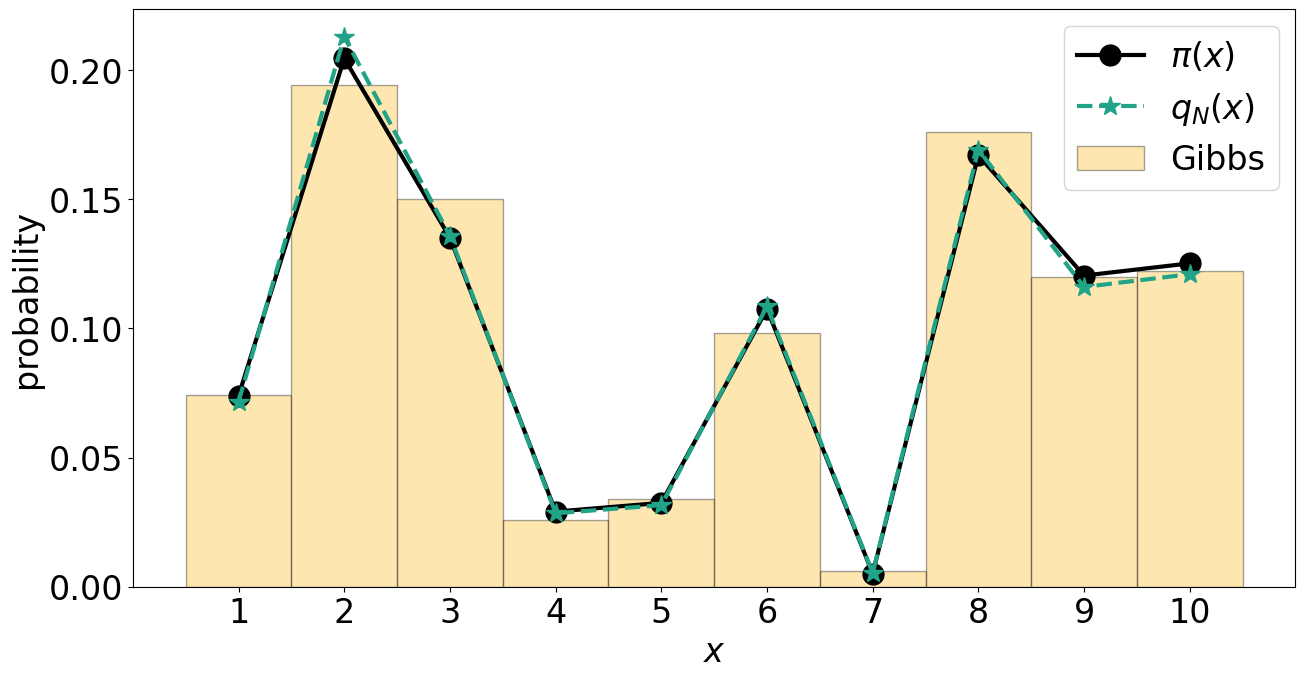

In [6]:
########################
########################
#     plot results     #
########################
########################

ttx=np.arange(0,K1)
#plt.bar(ttx+0.5,prbs, alpha=0.5, label=r'$\pi(x)$',color="black")
#plt.bar(ttx+0.5,qvar, alpha=0.5, label=r'$q_N(x)$',color="blue")
plt.plot(ttx+0.5,prbs,c="black", label=r'$\pi(x)$',lw=3,ms=15,marker='o')
plt.plot(ttx+0.5,qvar/np.sum(qvar),c='#20A386FF', label=r'$q_N(x)$',lw=3,ls='dashed',ms=15,marker='*')
plt.hist(gibbs_samples[0,:],density=True,bins=np.arange(0,K1+1),
         alpha=0.35, label='Gibbs', color="#FBB91FFF",ec='black')
plt.legend()
plt.xlabel(r'$x$')
plt.xticks(ticks=np.arange(0,K1)+0.5,labels=np.arange(1,1+K1))
plt.ylabel('probability')

In [7]:
gibbs_density=plt.hist(gibbs_samples[0,:],density=True,bins=np.arange(0,K1+1),
                       alpha=0.35, label='Gibbs', color="#FBB91FFF",ec='black')[0]
plt.clf()
elbo_qN=elbo_exact(np.log(qvar/np.sum(qvar)),np.log(prbs))
elbo_gibbs=elbo_exact(np.log(gibbs_density),np.log(prbs))
print('ELBO(qN||π)='+str(elbo_qN))
print('ELBO(qGibbs||π)='+str(elbo_gibbs))

ELBO(qN||π)=-0.00040329033243014217
ELBO(qGibbs||π)=-0.002063302048339602


<Figure size 1500x750 with 0 Axes>

## 2D toy example

Now we generate a two-dimensional synthetic example
where $\pi$ is a distribution over 
$\mathcal{X}=\{1,\dots,4\}\times\{1,\dots,5\}$.
We approximate $\pi$ with a MAD Mix $q_N$
of depth $N=500$ and with a uniform reference 
$q_0\sim\mathsf{U}(\mathcal{X})$.
We also target $\pi$ with a standard Gibbs sampler
run for 50,000 iterations, where only the last 500 are kept.

Below we show plots of the exact marginal densities $q_N(x_m)$ compared to $\pi(x_m)$,
$m=1,2$, along with a corresponding histogram of samples from the Gibbs sampler.

In [8]:
########################
########################
# target specification #
########################
########################
np.random.seed(2023)
K1=4
K2=5
prbs=np.random.rand(K1,K2)
prbs=prbs/np.sum(prbs)
def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs
    #
    # inputs:
    #    x    : (2,d) array with state values
    #    axis : int, full conditional to calculate; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,K_{axis+1}) array with d conditionals 
    
    ext_lprb=np.log(np.moveaxis(np.repeat(prbs[:,:,np.newaxis],x.shape[1],axis=-1),2,0)) # stack d copies of logp vertically
    if axis==None: return np.squeeze(ext_lprb[np.arange(0,x.shape[1]),x[0,:],x[1,:]]) # for each d, return lp(x)
    if axis==0: return ext_lprb[np.arange(0,x.shape[1]),:,x[1,:]]
    if axis==1: return ext_lprb[np.arange(0,x.shape[1]),x[0,:],:]
    raise Exception("Axis out of bounds - there aren't that many variables")

In [9]:
########################
########################
#    MAD Mix approx    #
########################
########################

# reference specification
lq0 = lambda x,u : -np.log(K1*K2)*np.ones(x.shape[1])
def randq0(size): return np.vstack((np.random.randint(0,K1,size),np.random.randint(0,K2,size))).T,np.random.rand(size,size)

N=500 # number of steps in qN
xi=np.pi/16

# evaluate density
# first create a grid of values of x1 and x2
# adapted from https://stackoverflow.com/questions/27286537/numpy-efficient-way-to-generate-combinations-from-given-ranges
x = np.mgrid[0:K1,0:K2] 
x = np.rollaxis(x, 0, 3)
x = x.reshape((K1*K2,2)).T
myx=np.copy(x)
# now sample u and evaluate density
u=np.random.rand(2,K1*K2)
qvar=np.exp(lqN(x,u,N,lq0,lp,xi))
myqvar=qvar.reshape(prbs.shape) # to move back from (K1*K2,) to (K1,K2) array

In [10]:
########################
########################
#    Gibbs sampling    #
########################
########################
np.random.seed(2023)
x0=np.array([np.random.randint(low=0,high=K1),np.random.randint(low=0,high=K2)])
gibbs_samples=gibbs_sampler(x0=x0,steps=N,lp=lp,burnin_pct=0.99,verbose=True)

Text(0, 0.5, 'probability')

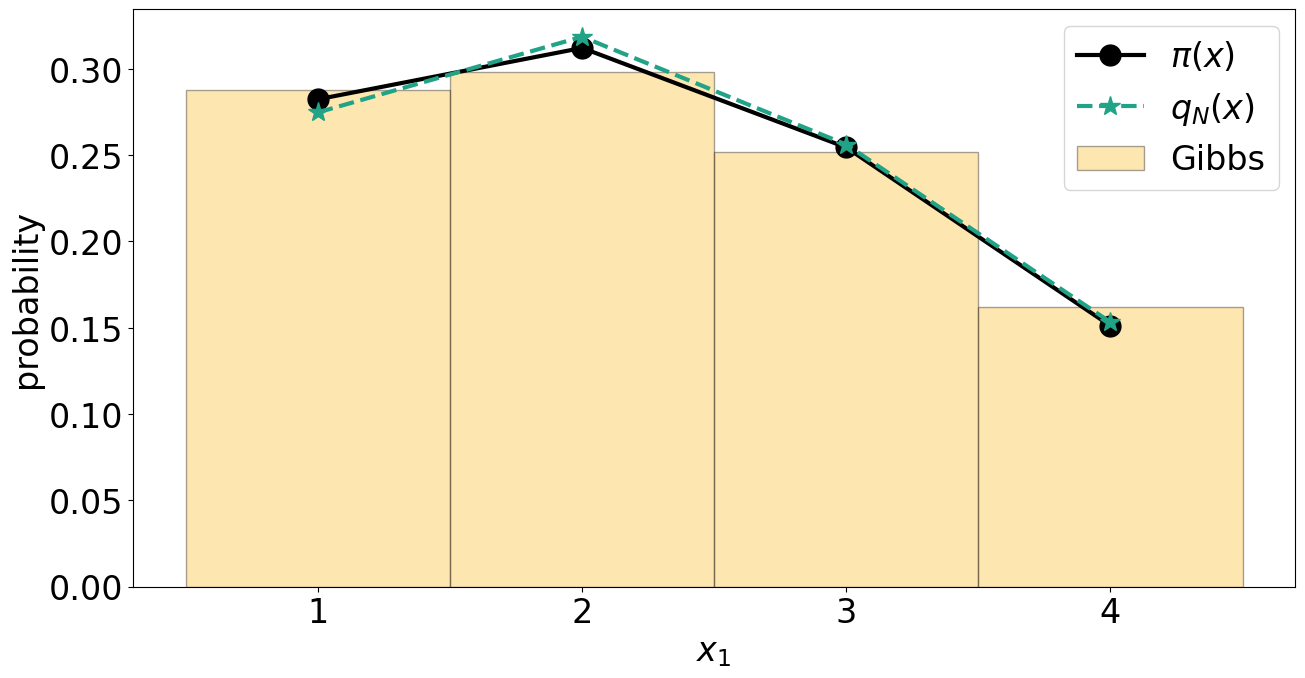

In [11]:
########################
########################
#   plot x1 results    #
########################
########################

ttx=np.arange(0,K1)
plt.plot(ttx+0.5,np.sum(prbs,axis=1),c="black", label=r'$\pi(x)$',lw=3,ms=15,marker='o')
plt.plot(ttx+0.5,np.sum(myqvar,axis=1),c='#20A386FF', label=r'$q_N(x)$',lw=3,ls='dashed',ms=15,marker='*')
plt.hist(gibbs_samples[0,:],density=True,bins=np.arange(0,K1+1),
         alpha=0.35, label='Gibbs', color="#FBB91FFF",ec='black')
plt.legend()
plt.xlabel(r'$x_1$')
plt.xticks(ticks=np.arange(0,K1)+0.5,labels=np.arange(1,1+K1))
plt.ylabel('probability')

Text(0, 0.5, 'probability')

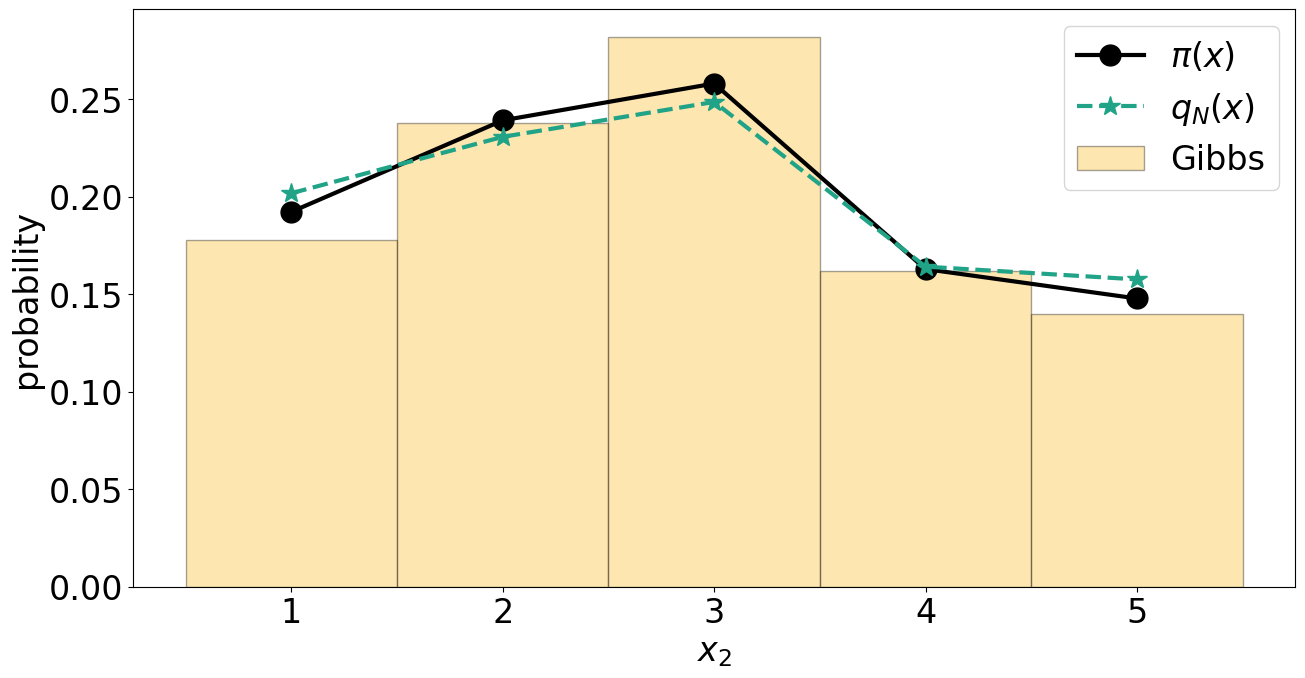

In [12]:
########################
########################
#   plot x2 results    #
########################
########################

ttx=np.arange(0,K2)
plt.plot(ttx+0.5,np.sum(prbs,axis=0),c="black", label=r'$\pi(x)$',lw=3,ms=15,marker='o')
plt.plot(ttx+0.5,np.sum(myqvar,axis=0),c='#20A386FF', label=r'$q_N(x)$',lw=3,ls='dashed',ms=15,marker='*')
plt.hist(gibbs_samples[1,:],density=True,bins=np.arange(0,K2+1),
         alpha=0.35, label='Gibbs', color="#FBB91FFF",ec='black')
plt.legend()
plt.xlabel(r'$x_2$')
plt.xticks(ticks=np.arange(0,K2)+0.5,labels=np.arange(1,1+K2))
plt.ylabel('probability')

In [13]:
gibbs_density=plt.hist2d(gibbs_samples[0,:],gibbs_samples[1,:],density=True,
                         bins=[np.arange(0,K1+1),np.arange(0,K2+1)],
                         alpha=0.35, label='Gibbs', color="#FBB91FFF",ec='black')[0]
plt.clf()
elbo_qN=elbo_exact(np.log(myqvar/np.sum(myqvar)),np.log(prbs))
elbo_gibbs=elbo_exact(np.log(gibbs_density),np.log(prbs))
print('ELBO(qN||π)='+str(elbo_qN))
print('ELBO(qGibbs||π)='+str(elbo_gibbs))

ELBO(qN||π)=-0.002000021625141389
ELBO(qGibbs||π)=-0.012151424983941169


<Figure size 1500x750 with 0 Axes>